In [1]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


2025-06-14 18:05:33.826459: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749924334.085234      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749924334.159589      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def extract_label_from_filename(filename):
    emotion_code = int(filename.split('-')[2])
    emotion_map = {
        1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad',
        5: 'angry', 6: 'fearful', 7: 'disgust', 8: 'surprised'
    }
    return emotion_map.get(emotion_code)

# Load file paths and labels
file_paths = []
labels = []

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith('.wav'):
            label = extract_label_from_filename(filename)
            if label:
                path = os.path.join(dirname, filename)
                file_paths.append(path)
                labels.append(label)

df = pd.DataFrame({'audio': file_paths, 'label': labels})


In [3]:
def extract_mfcc_with_deltas(filename, fixed_length=130):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc = librosa.util.fix_length(mfcc, size=fixed_length, axis=1)

    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)

    combined = np.concatenate((mfcc, delta, delta2), axis=0)
    return combined.T  # Shape: (fixed_length, 39)

X_features = [extract_mfcc_with_deltas(f) for f in df['audio']]
X = np.array(X_features)


In [4]:
enc = OneHotEncoder(sparse=False)
y = enc.fit_transform(df[['label']])


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Dropout, Flatten

model = Sequential([
    
    
    Conv1D(64, 3, padding='same', activation='relu', input_shape=(X.shape[1], X.shape[2])),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(128, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Bidirectional(LSTM(123, return_sequences=False)),
    BatchNormalization(),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(y.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop =EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-14 18:07:41.419064: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.2650 - loss: 2.3573 - val_accuracy: 0.1684 - val_loss: 2.2813
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.4016 - loss: 1.7197 - val_accuracy: 0.3507 - val_loss: 1.7864
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.4869 - loss: 1.4330 - val_accuracy: 0.5156 - val_loss: 1.3365
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.5516 - loss: 1.2543 - val_accuracy: 0.5694 - val_loss: 1.1509
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.6003 - loss: 1.1135 - val_accuracy: 0.4688 - val_loss: 1.5905
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.6461 - loss: 0.9996 - val_accuracy: 0.5451 - val_loss: 1.3297
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.6817 - loss: 0.8831 - val_accuracy: 0.6892 - val_loss: 0.8264
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.7083 - loss: 0.8117 - val_accuracy: 0

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
              precision    recall  f1-score   support

       angry       0.97      0.88      0.93        77
        calm       0.97      0.87      0.92        77
     disgust       0.90      0.97      0.94        77
     fearful       0.95      0.95      0.95        77
       happy       0.99      0.96      0.97        77
     neutral       0.79      0.87      0.82        38
         sad       0.93      0.92      0.93        77
   surprised       0.86      0.95      0.90        76

    accuracy                           0.93       576
   macro avg       0.92      0.92      0.92       576
weighted avg       0.93      0.93      0.93       576



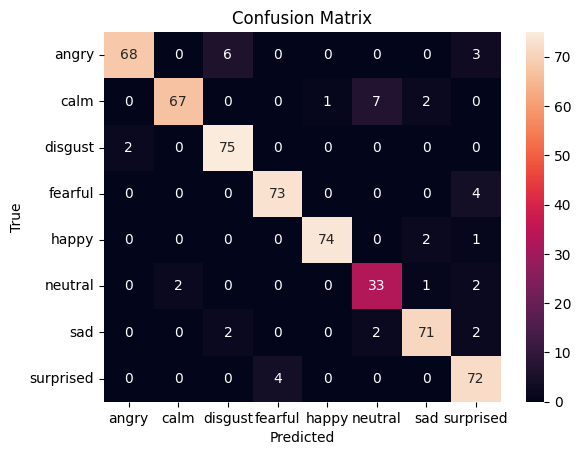

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred = model.predict(X_val)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)
target_names = enc.categories_[0]

# Classification report
print(classification_report(y_true, y_pred_labels, target_names=target_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



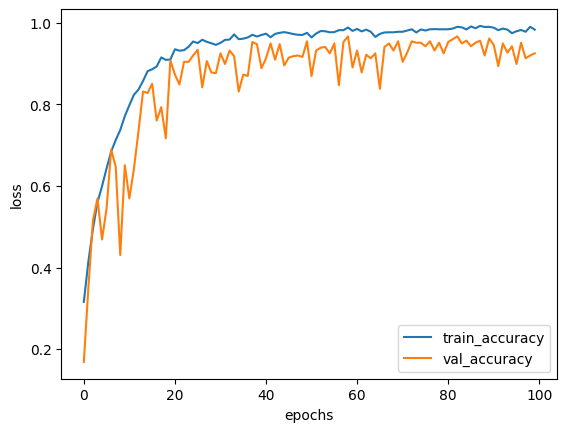

In [8]:


acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epochs=range(len(acc))
plt.plot(epochs,acc,label='train_accuracy')
plt.plot(epochs,val_acc,label='val_accuracy')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()



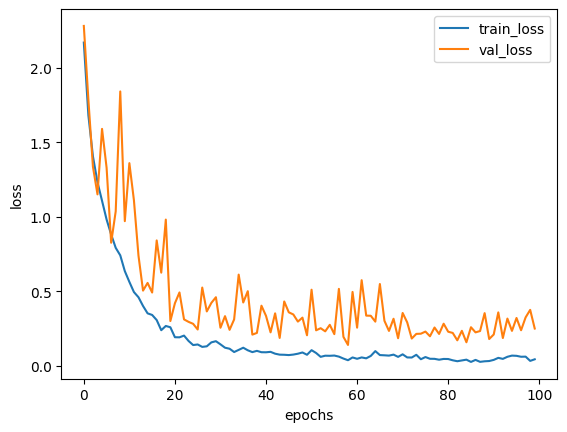

In [9]:


loss=history.history['loss']
val_loss=history.history['val_loss']
plt.plot(epochs,loss,label='train_loss')
plt.plot(epochs,val_loss,label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

